In [ ]:
# !pip install pymap2d
# !pip install shapely

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import project
from CMap2D import CMap2D, gridshow
import imageio as Image
import glob
from scipy.spatial.transform import Rotation as R
import os
from scipy.special import softmax
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from PIL import Image

## Loading poses with localization (tf_echo map -> camera_link)

In [ ]:
path_input = "../Results/Poses_Results/TF_with_localization/map_camera.txt"
path_output = "../Results/Poses_Results/TF_with_localization/map_camera_parsed.txt"

project.parse_pose_from_TF(path_input, path_output)
poses_TF_localization = pd.read_csv(path_output)

In [ ]:
poses_TF_localization.head(5)

### Load the occupancy grid and visualise the poses on the occupancy grid to see the trajectory of robot

In [ ]:
map = CMap2D("../Results/Map", "rtabmap")
occ_grid = map.occupancy()
origin = map.origin_xy()
x = poses_TF_localization['X']
y = poses_TF_localization['Y']
positions = np.zeros((x.shape[0],2))
print(positions.shape)
positions[:,0] = x
positions[:,1] = y
ij_positions = map.xy_to_ij(positions)
plt.figure(figsize=(15,15))
gridshow(occ_grid, cmap='Greys')
plt.scatter(ij_positions[:,0], ij_positions[:,1], s=7, )
print("map origin spatial:", origin)

origin_ij = map.xy_to_ij(origin.reshape(1,-1))
print("origin ij:", origin_ij)


### Load an rgb image and create the array of pixel coordinates

In [ ]:
img = Image.v2.imread("../Results/RGBD/segment/8603.168000.jpg")

pixels = np.zeros((img.shape[1]*img.shape[0], 3), int)
count = 0
for i in range(img.shape[1]):
    for j in range(img.shape[0]):
        pixels[count, :] = [i,j,1]
        count +=1

### initialise the values for camera intrinsic matrix

In [ ]:
K = np.array([554.3827128226441, 0.0, 320.5, 0.0, 554.3827128226441, 240.5, 0.0, 0.0, 1.0])
# camera intrinsic matrix
K = K.reshape(3,3)
K_inv = np.linalg.inv(K)

### Convert the pixel coordinates into camera rgb frame. 
(Currently the coordinates in this frame will be in canonical frame. we need to bring this into optical fram which is the camera frame)

In [ ]:
camera_rgb_frame = (np.matmul(K_inv, pixels.T)).T # dimension [n,3]

### create matrix of depth values for all the images

In [ ]:
depth_dir = '../Results/RGBD/depth/*.png'
depth_images = sorted(glob.glob(depth_dir))

z = np.zeros((len(depth_images), pixels.shape[0], 1))
for i in range(z.shape[0]):
    depth = Image.v2.imread(depth_images[i])
    for j in range(z.shape[1]):
        z[i,j,0] = depth[int(pixels[j,1]), int(pixels[j,0])] / 1000
    print(i)

### Create function to make homogenous transformation matrix

In [ ]:
def homogenous(roll, pitch, yaw, translation):
    rotation = R.from_euler('xyz', [roll, pitch, yaw])
    rotation = rotation.as_matrix()
    # translation = -np.matmul(rotation, translation)
    homogeneous_matrix = np.eye(4)
    homogeneous_matrix[:3, :3] = rotation
    homogeneous_matrix[:3, 3:] = translation

    return homogeneous_matrix

### Create function to plot the map with the transformed point coordinates

In [ ]:
def plot_scatter(i, ij_positions, poses,map_frame):
    global depth_images
    r = 20
    plt.figure(figsize=(15,15))
    gridshow(occ_grid)

    dx = r * np.cos(poses['Yaw'][i])
    dy = r * np.sin(poses['Yaw'][i])
    x = ij_positions[i,0]
    y = ij_positions[i,1]

    name = os.path.basename(depth_images[i])
    plt.scatter(map_frame[:,1], map_frame[:, 0], s=25, c= 'b')
    plt.arrow(x, y, dx, dy, width=1, ec='r', fc='g')
    plt.scatter(x, y, s=25 , c='r')
    plt.savefig("../Results/plots/{}".format(name))
    plt.close()

### create matrix of transformation from canonical frame to optical frame

In [ ]:
roll = -1.571
pitch = 0.00
yaw = -1.571
translation = np.array([[0.00, 0.00, 0.00]]).T
H = homogenous(roll, pitch, yaw, translation)

### create matrix of tranformation matrix from camera frame to map frame

In [ ]:
n_r_t = np.zeros((poses_TF_localization.shape[0], 4, 4))
for i in range(poses_TF_localization.shape[0]):
    tx = poses_TF_localization['X'][i]
    ty = poses_TF_localization['Y'][i]
    tz = poses_TF_localization['Z'][i]
    translation = np.array([[tx, ty, tz]]).T
    roll = poses_TF_localization['Roll'][i]
    pitch = poses_TF_localization['Pitch'][i]
    yaw = poses_TF_localization['Yaw'][i]
    n_r_t[i] = homogenous(roll, pitch, yaw, translation)


### Final loop
We first multiply the pixel coordinates with the corresponding depth values associated with the image.

Then convert these coordinates which are currently in canonical frame into optical frame / camera frame.

Then convert these coordinates from the optical frame into the map frame. 

In [ ]:
mask = False
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    camera_rgb_frame_z = (camera_rgb_frame * zi)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T

    if(mask):
        map_height_mask = map_frame[:,2] > np.mean(map_frame[:,2])
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_floatij = map.xy_to_floatij(map_frame_xy)
    # plot_scatter(i, ij_positions, poses_TF_localization, map_frame_floatij)
    

### Create visualisation from plots

In [ ]:
images_dir  = "../Results/plots/*.png"
images = sorted(glob.glob(images_dir))
image = []
for idx,i in enumerate(images):
    img = Image.v2.imread(i)
    image.append(img)

Image.mimsave('../images/camera_motion.gif', image, fps= 10)

### Camera motion visualisation

In [ ]:
from IPython.display import Image as im
im(url='../images/camera_motion.gif')  


### Experiments (to be removed)

#### loading the labels
The labels are of the dimension  [width*height, number of label classes] .

The values are obtained from the last layer of esanet and hence are the probability gradients predicted by esanet for each label class.

In [ ]:
labels_dir = "../../gradients/*.npy"
labels = sorted(glob.glob(labels_dir))

### assigning labels by adding up all the probabilities that points to the same cell or by multiplying the new probabilities for each label with its previous probability in the same cell

In [ ]:
occ_grid_colorized = np.ones((occ_grid.shape[0], occ_grid.shape[1], 3), np.uint8) * 255
mask_height = True
occ_labels = {}
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    """The depth sensor has a limit of 5 meters. so in order to account for false segmentation values thet may come
    up due to this cutoff"""
    depth_mask = np.squeeze(zi <= 4.5)
    
    #depth filtered camera_rgb_frame pixel coordinates
    camera_rgb_frame_z = np.zeros_like(camera_rgb_frame)
    camera_rgb_frame_z[depth_mask] = camera_rgb_frame[depth_mask] * zi[depth_mask]
#     print(camera_rgb_frame_z)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T
    
    # Filtering out all the points that are outside a range of optical axis height
    if(mask_height):
        map_height_mask = (map_frame[:,2] <= 0.6675) & (map_frame[:,2] >= 0.0)
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

        # print(np.unique(map_frame_xy))
        # print(map_frame_xy.shape)
        
    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_ij = map.xy_to_ij(map_frame_xy)
    mask = occ_grid[map_frame_ij[:,0], map_frame_ij[:,1]] == 1
    
    label = np.load(labels[i])
    for j in range(map_frame_ij.shape[0]):

        if(mask[j]):
            key = f"key_{map_frame_ij[j,0]}_{map_frame_ij[j,1]}"
        
            if (key in occ_labels):
                # multiplying probabilities
                '''since the probabilities are for the same pixel, i am considering the old probability as A and new 
                probability as B and  considering these two as dependent probabilities. 
                Now the probability of A and B is: P(A & B) =  P(A) * P(B). 
                So now probability of A given the new probability B is :
                P(A|B) = P(A & B) / P(B)'''
               
                prob_A = occ_labels[key]
                prob_B = label[j]
                prob_A_and_B = [old_label * new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
                prob_A_given_B = [prob_a_and_b / prob_b for prob_a_and_b, prob_b in zip(prob_A_and_B, prob_B)]
                occ_labels[key] = prob_A_given_B
                
                # adding probabilities
#                 occ_labels[key]= [old_label + new_label for old_label, new_label in zip(occ_labels[key] , label[j])]
#                 print(np.sum(occ_labels[key]))
#                 prob_sum = np.sum(occ_labels[key])
                # print(prob_sum)
#                 occ_labels[key] = [probability / prob_sum for probability in occ_labels[key]]
 
            else:
                occ_labels[key] = label[j]
                
                
#         for key in occ_labels.keys():
#             occ_labels[key] = softmax(occ_labels[key])
    
    print(i)
    

### Creating set of colors for the labels

In [ ]:
import random
random.seed(1)
def get_random_colors(num_colors):
    colors = []
    for _ in range(num_colors):
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        colors.append((r, g, b))
    return colors

def plot_colors(colors, label_names):
    num_colors = len(colors)
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.set_xlim(0, num_colors)
    ax.set_ylim(0, 1)
    ax.set_yticks([])

    for i, color in enumerate(colors):
        # label = str(i)
        normalized_color = (color[0] / 255, color[1] / 255, color[2] / 255)  # Normalize to range [0, 1]
        ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=normalized_color))
        ax.text(i + 0.5, 0.5, label_names[i], color='white', ha='center', va='center', fontsize=12, rotation=90)

    plt.savefig("color_labels.png")
    plt.show()



#### SUNRGBD

In [ ]:
num_labels = 37
label_names = ['wall',
  'floor',
  'cabinet',
  'bed',
  'chair',
  'sofa',
  'table',
  'door',
  'window',
  'bookshelf',
  'picture',
  'counter',
  'blinds',
  'desk',
  'shelves',
  'curtain',
  'dresser',
  'pillow',
  'mirror',
  'floor_mat',
  'clothes',
  'ceiling',
  'books',
  'fridge',
  'tv',
  'paper',
  'towel',
  'shower_curtain',
  'box',
  'whiteboard',
  'person',
  'night_stand',
  'toilet',
  'sink',
  'lamp',
  'bathtub',
  'bag']
unique_colors = get_random_colors(num_labels)

#### NYUV2

### assigning label to occupancy grid based on the highest probability

In [ ]:
for i in range(occ_grid_colorized.shape[0]):
    for j in range(occ_grid_colorized.shape[1]):
        key = f'key_{i}_{j}'
        if(key in occ_labels):
            values = occ_labels[key]
            values = softmax(values)
            label_id = np.argmax(values)
            occ_grid_colorized[i,j] = unique_colors[label_id]

### plotting the colorized occupancy grid

In [ ]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(occ_grid_colorized)
# plt.savefig("../Results/seg_map/nyuv2_seg_map_dependent_probs.png")

### Assign labels to cells by most occuring label

In [ ]:
occ_grid_colorized = np.ones((occ_grid.shape[0], occ_grid.shape[1], 3), np.uint8) * 255
mask_height = False
occ_labels = {}
for i in range(z.shape[0]):
    zi = z[i]
    
    #multiply depth
    camera_rgb_frame_z = (camera_rgb_frame * zi)
    
    #convert camera_rgb_frame into homogenous dimension
    ones = np.ones((z.shape[1],1))
    camera_rgb_frame_homo = np.column_stack((camera_rgb_frame_z,ones))

    #transform from canonical frame to optical frame ie camera frame
    camera_frame = H @ camera_rgb_frame_homo.T

    #transform from camera frame to map frame
    map_frame = (n_r_t[i] @ camera_frame).T
    # print((np.min(map_frame[:,2]) + np.max(map_frame[:,2]) / 2))
    if(mask_height):
        map_height_mask = (map_frame[:,2] <= 0.145) & (map_frame[:,2] >= 0.125)
        map_frame_masked = map_frame[map_height_mask]
        map_frame_xy = map_frame_masked[:,[0,1]]

        # print(np.unique(map_frame_xy))
        # print(map_frame_xy.shape)
    #convert the coordinates from spatial coordinates (x,y) to ij coordinates to plot in occupancy grid
    else:
        map_frame_xy = map_frame[:,[0,1]]
    map_frame_xy = map_frame_xy.copy(order='C')
    map_frame_ij = map.xy_to_ij(map_frame_xy)
    mask = occ_grid[map_frame_ij[:,0], map_frame_ij[:,1]] == 1
    
    # for j in range(occ_grid_colorized[map_frame_ij[:, 0], map_frame_ij[:, 1], :].shape[0]):
    #     if(mask[j].all()):
    #         # print(map_frame_ij[j, 0], map_frame_ij[j, 1])
    #         occ_grid_colorized[map_frame_ij[j, 0], map_frame_ij[j, 1], :] = labels[i,j,:]
    label = np.load(labels[i])
    # print(label.shape)
    for j in range(map_frame_ij.shape[0]):

        if(mask[j]):
            key = f"key_{map_frame_ij[j,0]}_{map_frame_ij[j,1]}"

            if (key in occ_labels):
                occ_labels[key]= np.vstack((occ_labels[key], np.argmax(label[j])))
            else:
                # print(np.argmax(label[j]))
                occ_labels[key] = np.argmax(label[j])
    print(i)

In [ ]:
for i in range(occ_grid_colorized.shape[0]):
    for j in range(occ_grid_colorized.shape[1]):
        key = f'key_{i}_{j}'
        if(key in occ_labels):
            values = occ_labels[key]
            unique_labels, count = np.unique(values, return_counts=True)
            unique_idx = np.argmax(count)
            unique_label = unique_labels[unique_idx]
            # print(unique_label)
            occ_grid_colorized[i, j, :] = unique_colors[unique_label]

In [ ]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(occ_grid_colorized)
plt.savefig("../Results/seg_map/seg_map_max_count.png")

### Viewing the polygon contours in the occupancy grid

In [ ]:
contours = map.as_closed_obst_vertices_ij()
plt.figure(figsize=(10,10))
gridshow(occ_grid)
plt.imshow(np.transpose(occ_grid_colorized, (1,0,2)), alpha=0.8)
polygons = []
for c in contours:
    poly = Polygon(c)
    polygons.append(poly)
    plt.plot(*poly.exterior.xy)

In [ ]:
occ_grid_poly_colorized = np.transpose(occ_grid_colorized,(1,0,2))
occ_grid_poly_colorized = np.ones_like(occ_grid_poly_colorized) *255


In [ ]:
occ_labels_in_poly = {}

occ_labels_in_poly.keys()

### labels based on polygon

created a new dictionary to save all the labels for a given polygon (contour of occupancies) 

In [ ]:

for i in range(occ_grid_poly_colorized.shape[0]):
    for j in range(occ_grid_poly_colorized.shape[1]):
        keyij = f'key_{i}_{j}'
        point = Point(np.array([[i,j]]))
        if keyij in occ_labels:
            for idx,polygon in enumerate(polygons):
                key = f'{idx}'
                
                if (point.within(polygon)):
                    if key in occ_labels_in_poly:
                        print(f'labels: {len(occ_labels[keyij])}')
                        occ_labels_in_poly[key] = np.vstack((occ_labels_in_poly[key],occ_labels[keyij]))
                    else:
                        print(f'labels: {len(occ_labels[keyij])}')
                        occ_labels_in_poly[key] = np.array(occ_labels[keyij]).reshape([1,-1])
                        
        

In [ ]:
occ_labels_in_poly.keys()

In [ ]:
occ_labels_in_poly['38'].shape

### assigning global label for a given polygon
assumption is a polygon will represent a single object

### method
using the method of dependent probabilities for a given polygon

In [ ]:
for key in occ_labels_in_poly:
    print(f'key: {key}')
    values =occ_labels_in_poly[key]
    print(f'number of observations in polygon: {len(values)}')
#     break
#     print(len(values))
    temp_label = []
    value = values[0,:]
    for i in range(1,values.shape[0]):
        prob_A = value
        prob_B = values[i,:]
        prob_A_and_B = [A * B for A,B in zip(prob_A, prob_B)] 
        value = prob_A_and_B / prob_B 
        
    value = softmax(value)    
    poly_label = np.argmax(value)
    print(f'polygon label: {poly_label}')
    occ_labels_in_poly[key] = poly_label

In [ ]:
for i in range(occ_grid_poly_colorized.shape[0]):
    for j in range(occ_grid_poly_colorized.shape[1]):
        keyij = f'key_{i}_{j}'
        point = Point(np.array([[i,j]]))
        if keyij in occ_labels:
            for idx,polygon in enumerate(polygons):
                key = f'{idx}'
                if (point.within(polygon)):
                    occ_grid_poly_colorized[i, j, :] = unique_colors[occ_labels_in_poly[key]]
            

In [ ]:
plot_colors(unique_colors, label_names)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(occ_grid_poly_colorized, (1,0,2)))
# for c in contours:
#     poly = Polygon(c)
#     polygons.append(poly)
#     plt.plot(*poly.exterior.xy)

plt.savefig('../Results/seg_map/sunrgbd_seg_map_polygon_label_wo_polygons.png')

#### Experiment on contours

In [ ]:
import cv2
gray = cv2.cvtColor(occ_grid_colorized, cv2.COLOR_RGB2GRAY)
binary_mask = gray >125
gray[binary_mask]  = 0
gray[~binary_mask] = 1
ret, thresh = cv2.threshold(gray, 11, 255,cv2.THRESH_BINARY)
thresh = thresh.astype(np.uint8)
kernel = np.ones((3,3),np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=1)
cv2_output = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
len(cv2_output[1])

In [ ]:
cont = cv2_output[0]
contours = [np.vstack([c[:,0,1], c[:,0,0]]).T for c in cont]
len(contours)

In [ ]:
print(occ_grid)

In [ ]:
print(np.unique(gray))

In [ ]:
plt.imshow(gray, cmap='Greys')

In [ ]:
poly = Polygon(contours[0])
plt.plot(*poly.exterior.xy)

### Annotation

In [43]:
# load chairs mask

chairs1 = 'masks/chairs_mask.png'
chairs2 = 'masks/chairs1_mask.png'

chairs1 = np.asarray(Image.open(chairs1))
chairs2 = np.asarray(Image.open(chairs2))

chairs = chairs1 + chairs2



In [19]:
chairs_ = chairs.reshape(-1, chairs.shape[2]) # reshape the original image into -1, 3; -1 is placeholder, so lets say you have a 
                                     # numpy array with shape (6,2), if you reshape it to (-1, 3), we know the second dim = 3
                                     # first dim = (6*2)/3 = 4, so -1 is replaced with 4
print(chairs_.shape)

counter, counts = np.unique(chairs_, axis=0, return_counts=True)

(1000000, 4)


In [20]:
print(counter)
print(counts)

[[ 65 232 120 254]
 [136   2 168 254]]
[ 45177 954823]


In [38]:
# mask = (chairs[:,:,:] == [65,232,120,254])
mask = (chairs[:,:,0] == 65)
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [46]:
chairs.shape

(1000, 1000, 4)

In [48]:
chairs[:,:,0][mask] = 172


In [49]:
chairs[mask]

array([[172, 232, 120, 254],
       [172, 232, 120, 254],
       [172, 232, 120, 254],
       ...,
       [172, 232, 120, 254],
       [172, 232, 120, 254],
       [172, 232, 120, 254]], dtype=uint8)

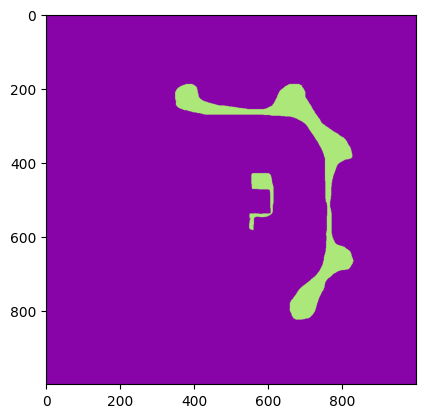

In [50]:
plt.imshow(chairs)